# Data Representation and Transformation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
data = pd.read_csv(os.path.join('data', 'Titanic_0.csv'))
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                                   Moran, Mr. James    male   NaN      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            330877   8.4583   NaN        Q

The `titanic` dataset contains both categorical, text, and numeric features. We will use this dataset to predict whether a passenger survived the Titanic or not. 

Let's split the data into training and testing sets and use the `Survived` column as a target.

In [3]:
y = data['Survived']
X = data.drop(columns='Survived')

In [4]:
X.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            141
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          549
Embarked         1
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [6]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            108
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          411
Embarked         1
dtype: int64

In [7]:
X_train.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [8]:
X_train[['Sex', 'Embarked']]

Sex Embarked
116    male        S
131    male        S
589  female        S
27     male        S
595    male        S
..      ...      ...
659  female        S
256    male        S
643    male        C
249  female        C
664  female        C

[534 rows x 2 columns]

Most of the classifiers are designed to work with numerical data. Therefore, we need to convert the categorical data into numeric features. The simplest way is to one-hot encode each categorical feature with the `OneHotEncoder`. Let's give an example for the `Sex` and `Embarked` columns. Note that we also encounter some data which are missing. We will use a `SimpleImputer` to replace the missing values with a constant values.

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

ohe = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_encoded = ohe.fit_transform(X_train[['Sex', 'Embarked']])
X_encoded.toarray()

array([[0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.]])

In [10]:
X_encoded

<534x6 sparse matrix of type '<class 'numpy.float64'>'
	with 1068 stored elements in Compressed Sparse Row format>

This way, it is possible to encode the categorical features. However, we also want to standardize the numerical features. Thus, we need to split the original data into 2 subgroups and apply a different preprocessing: (i) one-hot encoding for the categorical data and (ii) standard scaling for the numerical data. We also need to handle missing values in both cases. For the categorical column, we replace the missing values by the string `'missing_values'` which will be interpreted as a category on its own. For the numerical data, we will replace the missing data by the mean values of the feature of interest.

In [11]:
col_cat = ['Sex', 'Embarked']
col_num = ['Age', 'SibSp', 'Parch', 'Fare']

X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]
X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

In [12]:
from sklearn.preprocessing import StandardScaler

scaler_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc = scaler_cat.fit_transform(X_train_cat)
X_test_cat_enc = scaler_cat.transform(X_test_cat)

scaler_num = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

In [13]:
X_train_cat_enc

<534x6 sparse matrix of type '<class 'numpy.float64'>'
	with 1068 stored elements in Compressed Sparse Row format>

In [14]:
X_train_num_scaled

array([[-0.84978858,  0.42402614,  0.65645945,  0.06750954],
       [-1.00181375, -0.48169369, -0.45639562, -0.46804832],
       [ 1.35457638,  0.42402614,  2.88216959,  0.02222428],
       ...,
       [-2.26210241, -0.48169369,  0.65645945, -0.47082836],
       [-0.92580117,  1.32974597,  1.76931452,  4.36960987],
       [-1.15383892,  0.42402614, -0.45639562, -0.35761519]])

We should apply these transformations on the training and testing sets

In [15]:
import numpy as np
from scipy import sparse

X_train_scaled = sparse.hstack((X_train_cat_enc,
                                sparse.csr_matrix(X_train_num_scaled)))
X_test_scaled = sparse.hstack((X_test_cat_enc,
                               sparse.csr_matrix(X_test_num_scaled)))

Once the transformation is done, we can combine the informations which are all numerical now. Finally, we use our `LogisticRegression` classifier as a model.

In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_scaled, y_train)
accuracy = clf.score(X_test_scaled, y_test)
print('Accuracy score of the {} is {:.2f}'.format(clf.__class__.__name__, accuracy))

Accuracy score of the LogisticRegression is 0.74


The above pattern of first transforming the data and then fitting/scoring the classifier is exactly the one we saw before. Therefore, we would like to use a pipeline for such purpose. However, we would also like to have different processing on different columns of our matrix. The `ColumnTransformer` transformer or the `make_column_transformer` function should be used. It is used to automatically apply different pipeline on different columns.

In [17]:
from sklearn.compose import make_column_transformer

pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(SimpleImputer(), StandardScaler())
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs'))

pipe.fit(X_train, y_train)
accuracy = pipe.score(X_test, y_test)
print('Accuracy score of the {} is {:.2f}'.format(pipe.__class__.__name__, accuracy))

Accuracy score of the Pipeline is 0.74


Besides, it can also be used in another pipeline. Thus, we will be able to use all `scikit-learn` utilities as `cross_validate` or `GridSearchCV`.

In [18]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['Sex', 'Embarked']),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['Age', 'SibSp', 'Parch', 'Fare'])])),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(

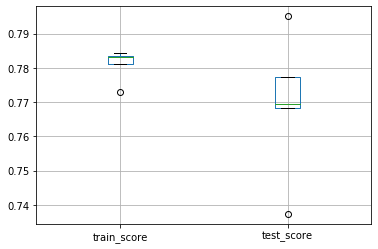

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

pipe_cat = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
pipe_num = make_pipeline(StandardScaler(), SimpleImputer())
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

pipe = make_pipeline(preprocessor, LogisticRegression(solver='lbfgs'))

param_grid = {'columntransformer__pipeline-2__simpleimputer__strategy': ['mean', 'median'],
              'logisticregression__C': [0.1, 1.0, 10]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
scores = pd.DataFrame(cross_validate(grid, X, y, scoring='balanced_accuracy', cv=5, n_jobs=-1, return_train_score=True))
scores[['train_score', 'test_score']].boxplot()

In [20]:
scores

fit_time  score_time  test_score  train_score
0  0.672801    0.006981    0.768182     0.783283
1  0.676790    0.005985    0.777273     0.781211
2  0.679782    0.004987    0.769318     0.784378
3  0.665820    0.005984    0.737374     0.783416
4  0.644875    0.004987    0.795034     0.772863